In [1]:
pip install tensorflow_gan


Note: you may need to restart the kernel to use updated packages.


In [2]:
from util import *
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Bidirectional, LSTM, Reshape, RepeatVector, TimeDistributed
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow_gan as tfgan
import tensorflow as tf
tf.compat.v1.enable_eager_execution() 

import matplotlib.pyplot as plt

import sys

import numpy as np
import pandas as pd

import os
import datetime

# Load Data
Loading from preprocessed numpy array

# Creating GAN

In [3]:
class LSTMGAN():
    def __init__(self, step_i, step_o, f, data):
        self.data = data
        self.step_input = step_i
        self.step_output = step_o
        self.feature_len = f
        self.in_shape = (self.step_input, self.feature_len)
        self.out_shape = (self.step_output, self.feature_len)
        self.dis_shape = (self.step_input+self.step_output, self.feature_len)

        optimizer = Adam(0.0001, 0.4)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        # Trains the generator to imitate input data
        self.generator.compile(loss='mean_squared_error',
            optimizer=optimizer)
        
        # The generator takes noise as input and generates song
        noise = Input(shape=self.in_shape)
        gen_output = self.generator(noise)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(merge_time_series(noise, gen_output))

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(noise, valid)
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        

    def build_generator(self):

        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=self.in_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(128)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(self.out_shape[0] * self.out_shape[1]))
        model.add(Reshape(self.out_shape))
        # model.summary()

        noise = Input(shape=self.in_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
        
        model.add(Bidirectional(LSTM(128, activation = 'relu', return_sequences=True), input_shape=self.dis_shape))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(128, activation = 'relu')))
        model.add(Dense(1, activation = 'linear'))
        #model.summary()

        img = Input(shape=self.dis_shape)
        validity = model(img)

        return Model(img, validity)
    
    
    def train(self, epochs, batch_size=128, save_interval=50, log_interval=50):
    
        start_time = datetime.datetime.now()

        # Load the dataset
        (X_train_input, X_train_output) = split_time_series(self.step_input, self.step_output, self.data)

        # normalize

        # Adversarial ground truths
        valid = np.ones(batch_size)
        fake = np.zeros(batch_size)
        
        print("start training....")

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            # Select a random half of songs
            idx = np.random.randint(0, X_train_input.shape[0], batch_size)
            real_input= X_train_input[idx]
            real_output= X_train_output[idx]
            
           
            
            (real_input, scalers) = batch_standardize(real_input)
            real_output = batch_transform(real_output, scalers)
            
            # Sample noise and generate a batch of new prices
            noise = np.random.normal(0, 1, (batch_size,self.step_input,self.feature_len))
            gen_output = self.generator.predict(noise, batch_size = batch_size)
            real_series = merge_time_series(real_input,real_output)
            fake_series = merge_time_series(real_input,gen_output)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(real_series, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_series, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            # First training (wants generator to imitate real data)
            g_loss1 = self.generator.train_on_batch( np.array(real_input), np.array(real_output))
            
            # Second training (wants discriminator to mistake songs as real)
            g_loss2 = self.combined.train_on_batch(noise, valid)
            g_loss = 0.5 * np.add(g_loss1, g_loss2)

            # Plot the progress
            if log_interval and epoch % log_interval == 0:
                cur_time = datetime.datetime.now()
                print ("epoch %d ------------------------------------------------------" % epoch)
                print( "D loss: %f, acc.: %.2f%%, G loss: %f" % (d_loss[0], 100*d_loss[1], g_loss))
                print("time elapsed : ", cur_time - start_time)
                print("input:\n", scalers[0].inverse_transform( real_input[0]))
                print("fake_output:\n", scalers[0].inverse_transform( gen_output[0]))
                print("real_output:\n", scalers[0].inverse_transform( real_output[0]))

            # If at save interval => save model
            if (epoch + 1) % save_interval == 0:
                self.generator.save("LSTM_generator.h5")

# Model Summary
I couldn't train the model on this online notebook so I trained it locally for 1000 epochs and uploaded the h5 file.

In [4]:
data = load_data("./data_stock/Dowjones_average.csv")
step_i = 5
step_o = 1
feature_len = data.shape[1]
lstmgan = LSTMGAN(step_i, step_o, feature_len , data)
lstmgan.train(epochs=5000, batch_size=50, save_interval=1000, log_interval=1000)

start training....
epoch 0 ------------------------------------------------------
D loss: 2.476349, acc.: 50.00%, G loss: 5.215109
time elapsed :  0:00:13.318690
input:
 [[34198.96 34432.68 33854.69 34416.99]
 [34509.72 34975.19 34509.72 34754.94]
 [34757.57 34842.62 34661.95 34746.25]
 [34723.79 34951.35 34486.51 34496.06]
 [34507.15 34611.24 34318.94 34378.34]]
fake_output:
 [[34542.69  34760.645 34361.74  34557.39 ]]
real_output:
 [[34372.71 34449.83 34115.1  34377.81]]
epoch 1000 ------------------------------------------------------
D loss: 0.678322, acc.: 56.33%, G loss: 1.393313
time elapsed :  0:02:34.549752
input:
 [[36321.59 36595.82 36246.45 36585.06]
 [36636.   36934.84 36636.   36799.65]
 [36722.6  36952.65 36400.39 36407.11]
 [36409.05 36464.19 36200.68 36236.47]
 [36249.59 36382.84 36111.53 36231.66]]
fake_output:
 [[35600.836 36006.227 35798.92  35999.71 ]]
real_output:
 [[36175.21 36175.21 35639.91 36068.87]]
epoch 2000 -------------------------------------------------

# Generate Stock Prices
Generating random input and letting model predict output

In [5]:
# import util
# import importlib
# importlib.reload(util)
# from util import *

(real_input, real_output) = split_time_series_disjoint(step_i, step_o, data)
(stzd_input, scalers) = batch_standardize(real_input)
MA5 = moving_average(5, data)
MA5 = MA5[:len(real_input) * step_o].reshape(-1, step_o, MA5.shape[-1])

stzd_pred_output = lstmgan.generator(tf.convert_to_tensor(stzd_input)).numpy()

pred_output = batch_inverse_transform(stzd_pred_output, scalers)
stzd_real_output = batch_transform(real_output, scalers)
stzd_MA5 = batch_transform(MA5, scalers)

print(f'predicted price:\n{pred_output[0]},\nreal price:\n{real_output[0]},\nMA5:\n{MA5[:5]} \
       ,\nstandardized predicted price:\n{stzd_pred_output[0]} \
       ,\nstandardized real price:\n{stzd_real_output[0]} \
       ,\nstandardized MA5:\n{stzd_MA5[0]}')

predicted price:
[[18617.09  18892.277 18064.215 18604.398]],
real price:
[[19722.19 20737.7  19649.25 20704.91]],
MA5:
[[[19957.452 20392.716 19056.954 19797.88 ]]

 [[19804.48  20264.386 19010.352 19691.386]]

 [[19976.81  20570.506 19334.528 19951.712]]

 [[20304.484 21000.992 19784.522 20444.708]]

 [[20633.548 21360.254 20259.522 20937.268]]]        ,
standardized predicted price:
[[-2.6278226 -2.0721025 -1.8578848 -1.3327494]]        ,
standardized real price:
[[-0.4612385   0.47642245  1.10846713  1.01287107]]        ,
standardized MA5:
[[0. 0. 0. 0.]]


# Plot


In [6]:
#transform everything into columns                
stzd_pred_data = columnify(stzd_pred_output)
stzd_real_data = columnify(stzd_real_output)
stzd_MA5_data = columnify(stzd_MA5)
pred_data = columnify(pred_output)
real_data = columnify(real_output) 
MA5_data = columnify(MA5)

titles = ["Open Price", "High Price", "Low Price", "Close Price"]
columns = len(titles)

mae = MAE(real_data[3],pred_data[3])
rmse = RMSE(real_data[3],pred_data[3])
mape = MAPE(real_data[3],pred_data[3])
ar = AR(real_data[3],pred_data[3])

MA5_mae = MAE(real_data[3],MA5_data[3])
MA5_rmse = RMSE(real_data[3],MA5_data[3])
MA5_mape = MAPE(real_data[3],MA5_data[3])
MA5_ar = AR(real_data[3],MA5_data[3])

print('LSTM: MAE=',mae,'RMSE=',rmse,'MAPE=',mape,'AR=',ar)
print('MA5: MAE=',MA5_mae,'RMSE=',MA5_rmse,'MAPE=',MA5_mape,'AR=',MA5_ar)


LSTM: MAE= 208.2231099114806 RMSE= 300.975372022626 MAPE= 0.007173154374872457 AR= 30.21243010752691
MA5: MAE= 354.6581888412019 RMSE= 485.25392684563343 MAPE= 0.012146528669668083 AR= 6.90922580645156


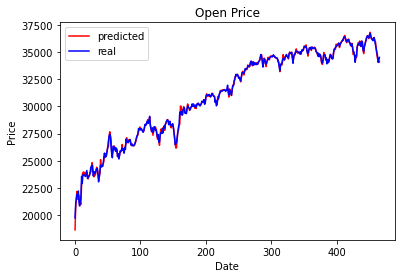

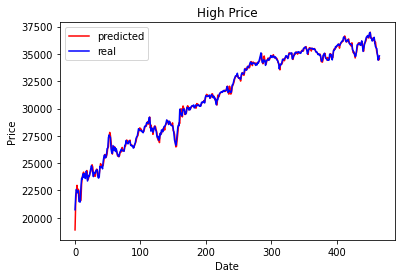

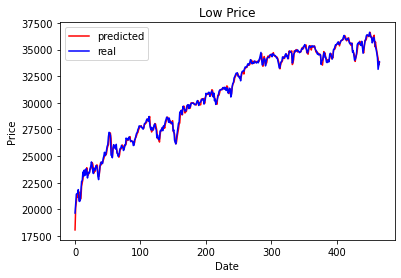

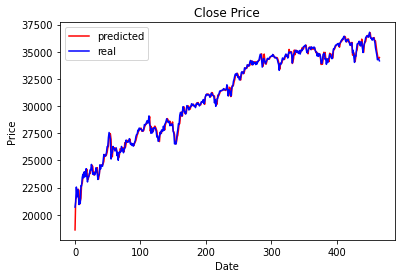

In [7]:
for i in range(columns):
    length = len(pred_data[i])
    plt.plot(range(length), pred_data[i], color ='r', 
             label ='predicted')

    plt.plot(range(length), real_data[i], color ='b', 
             label ='real')

    # naming of x-axis and y-axis
    plt.xlabel('Date')
    plt.ylabel('Price')

    # naming the title of the plot
    plt.title(titles[i])

    plt.legend()
    plt.show()